# CZ1015 Mini Project

### FEP2T02
- Agrawal Rachita (U1922919L)
- Au Yi Xian (U1923991D)
- Lim Ming Wei (U1922670A)
- Ong Wei Xuan, Justin (U1922735E)

# Problem

### Dataset 5: Epileptic Seizure Recognition
- EEG Data recorded from 5 healthy volunteers and 5 epileptic patients


- The 5 categories of data sets that are provided to us are:
    - Healthy patient (Eyes Open)
    - Healthy patient (Eyes Closed)
    - Epileptic patient (Opp. Epileptogenic Zone)
    - Epileptic patient (Epileptogenic Zone)
    - Seizure Activity
    
    
(Epileptic patients are those who are prone to having a seizure. But while recording the EEG signal, they did not have a seizure)

# Objective
## Categorise into Healthy, Epileptic and Seizure by performing classification on the time series data

[Paper Describing Data Source](http://users.fs.cvut.cz/ivo.bukovsky/PROJEKT/Data/Realna/BIO/EEG/reference/PRE61907.pdf)

Data Source (reprocessed): https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition#

Data Source (Original): http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3

Paper: http://users.fs.cvut.cz/ivo.bukovsky/PROJEKT/Data/Realna/BIO/EEG/reference/PRE61907.pdf


# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import find_peaks
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown

sb.set()

LABELS = {
    "Z": "Healthy (Eyes Open)",
    "O": "Healthy (Eyes Closed)",
    # N and F are from epileptic patients but measured during seizure free intervals
    "N": "Epileptic (Opp. Epileptogenic Zone)",
    "F": "Epileptic (Epileptogenic Zone)",
    "S": "Seizure Activity"
}

LABELS2 = {
    1: "Time Series with Low Pass Filter (40Hz)",
    2: "Rolling Mean of Time Series with LPF"
}

# Note: Data Source

Throughout the notebook, we work with the 500 text files found at http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3. The files can be downloaded with the following bash script:

```
curl -O http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
curl -O http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
curl -O http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip
curl -O http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip
curl -O http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip
mkdir seizure
unzip '*.zip' -d seizure > /dev/null && ls seizure/ | wc -l
rename 's/\.TXT/\.txt/' seizure/*
```

The data from above has been provided in the archive submitted.

## Note: Exemplary Time Series (Per Category)

The source states that the following series are exemplary time series for their category:
* Set Z (Healthy, Eyes open): Z093
* Set O (Healthy, Eyes closed): O015
* Set N (Patient, Opposite hemisphere from Set D): N062
* Set F (Patient, Epileptogenic zone): F021
* Set S (Patient, segment selected from all sites with seizure activity): S056

## Thus, these text files are going to be used in the following visualization.

In [2]:
overall = []

for fname in ["Z093", "O015", "N062", "F021", "S056"]:
    
    df = pd.read_csv(f'seizure/{fname}.txt', header=None)
    
    df.index.name = "samples"
    df.rename(columns={0: "magnitude"}, inplace=True)
    df.reset_index(inplace=True)
    
    df["class"] = f'{fname} - {LABELS[fname[0]]}'
    overall.append(df)

overall_df = pd.concat(overall, ignore_index=True)

fig = px.line(overall_df, x="samples", y="magnitude", color="class", labels={
    "samples": "Samples",
    "magnitude": "Magnitude",
    "class": "Class"
})

fig.update_traces({
    "line_width": 1
})

fig.update_layout(legend={
    "xanchor": "right",
    "x": 1,
    "y": 1
})

display(Markdown("# Raw Time Series Data"))
#display(Markdown("(One sample per category)"))

fig.show()

# Raw Time Series Data

## Note: Low Pass Filter

- Apply Low Pass Filter with cutoff frequency of 40Hz

"The sampling rate of the data was 173.61 Hz. For a more detailed description of the data please refer to the manuscript  Please note, however, that the time series have the spectral bandwith of the aquisition system, which is 0.5 Hz to 85 Hz. The application of a low-pass filter of 40 Hz, as described in the manuscript, is regarded as the first step of analysis and therefore not carried out for the downloadable time series."

[Source](http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3)

In [3]:
from scipy.signal import butter, sosfilt

# freqs from http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3
FILTER_ORDER = 10
FILTER_FREQ = 40
SAMPLING_FREQ = 173.61

def lpf(datapoints):
    # lpf with cutoff=40Hz
    sos = butter(FILTER_ORDER, FILTER_FREQ, fs=SAMPLING_FREQ, output="sos")
    return sosfilt(sos, datapoints)

# Feature Extraction: Rolling Mean and Counting Peaks

# Data Visualization
- Applying the moving average (MA) model (rolling mean) on the time series data
    - What it does: takes an average of any subset of numbers, which is specified as the window
    - Plotting and comparing the time series data and the data obtained from applying the MA model
    - Thus, trying to see whether applying the model will help create variables for classification
    
    
- Counting the number of peaks after the moving average model has been applied

## Note: Window Size
- The moving average model requires a window size to be specified, which shall remain constant throughout the analysis. This window size is chosen based on the number of data points in 1/4th of a second. This variable may vary with different data sets.


- Since there are 4097 data points for a total of 23.5 seconds, 1/4th of a second shall include around 44 data points. This will be our window size.

In [4]:
totalDataPoints = 4097
totalTime = 23.5
windowSize = math.ceil((totalDataPoints/totalTime)/4)   #1/4th of a second

In [28]:
for name in ["Z093","F021","S056"]:    
    overall = []
    c = 0
    indices = 0
    time_series = 0
    for x in [1,2]:
        c += 1
        na="seizure/"+str(name)+".txt"
        df = pd.read_csv(na, header=None)
        df = pd.DataFrame(lpf(df))

        if c == 2:
            rollingMean = df.iloc[:,0].rolling(window=windowSize, center=True).mean()
            df = pd.DataFrame(rollingMean)
            time_series = df[0]
            indices = find_peaks(time_series)[0]

        df.index.name = "samples"
        df.rename(columns={0: "magnitude"}, inplace=True)
        df.reset_index(inplace=True)

        df["class"] = LABELS2[c]

        overall.append(df)

    overall_df = pd.concat(overall, ignore_index=True)

    fig = px.line(overall_df, x="samples", y="magnitude", color="class", labels={
        "samples": "Samples",
        "magnitude": "Magnitude",
        "class": "Class"
    })

    fig.update_traces({
        "line_width": 1
    })

    fig.update_layout(legend={
        "xanchor": "right",
        "x": 1,
        "y": 1
    })

    fig.add_trace(go.Scatter(
        x=indices,
        y=[time_series[j] for j in indices],
        mode='markers',
        marker=dict(
            size=7,
            color='red',
            symbol='x'
        ),
        name='Detected Peaks'
    ))
    if name == "Z093": 
        display(Markdown("# Healthy Patient, eyes open (Z093)"))
    elif name == "F021": 
        display(Markdown("# Epileptic Patient, epileptogenic zone (F021)"))
    else:
        display(Markdown("# Patient suffering from Seizure (S054)"))
    display(Markdown("(After applying the Low Pass Filter of 40Hz)"))

    fig.show()

# Healthy Patient, eyes open (Z093)

(After applying the Low Pass Filter of 40Hz)

# Epileptic Patient, epileptogenic zone (F021)

(After applying the Low Pass Filter of 40Hz)

# Patient suffering from Seizure (S054)

(After applying the Low Pass Filter of 40Hz)

# Data Preparation and Feature Extraction
- First, the text files are read into a dataframe
- Next, based on the rolling mean time series data and the number of peaks occuring in the data, simple computations were applied so as to prepare variables for the data classification. 
    - MeanAbsTS-RM variable: The absolute of the values of the subtraction of the time series data and the rolling mean data was taken for each data set. Then, the mean of these values was computed and stored as a variable defining that particular data set.
    - CountPeaksRM variable: The number of peaks in the rolling mean data for each data set defines this variable.


In [6]:
import glob

full_data = []
data_class = []

for filename in glob.glob("seizure/*.txt"):
    data = pd.read_csv(filename, header=None)
    full_data.append(pd.DataFrame(lpf(data)))
    data_class.append(filename[8])

cls_df = pd.DataFrame({"Class": data_class}, dtype="category")
cls_df["FullClass"] = cls_df.replace({"Class": LABELS})
full_df = pd.concat(full_data, axis="columns", ignore_index=True).transpose().join(cls_df)

assert full_df.shape == (500, 4099)

display(full_df.head())

0         1         2         3         4         5         6  \
0  0.019827 -0.021352 -0.076257 -0.106760 -0.164716 -0.240973 -0.269950   
1  0.436191  0.382811  0.326381  0.297403  0.276051  0.263850  0.250124   
2 -0.051855 -0.016777  0.012201 -0.064056 -0.199794 -0.303504 -0.330956   
3 -1.192662 -1.862200 -2.144352 -1.964385 -1.439736 -0.835779 -0.369085   
4  0.047279  0.061006  0.062531  0.117436  0.140313  0.065581 -0.036603   

          7         8         9  ...      4089      4090      4091      4092  \
0 -0.269950 -0.256224 -0.198269  ... -0.054905 -0.065581 -0.059481 -0.077782   
1  0.215045  0.146414  0.030503  ...  0.771723  0.742745  0.696991  0.672588   
2 -0.305029 -0.228772 -0.158615  ... -0.311129 -0.411789 -0.459068 -0.440767   
3 -0.028978  0.178442  0.277576  ... -1.281121 -0.849505 -0.308079  0.166241   
4 -0.085408 -0.056430 -0.010676  ... -0.082358 -0.067106 -0.045754 -0.010676   

       4093      4094      4095      4096  Class              FullClass  
0 -0.120486 -0.118961 -0.073207 -0.164716      O  Healthy (Eyes Closed)  
1  0.622259  0.509398  0.286727  0.480420      S       Seizure Activity  
2 -0.387386 -0.309604 -0.237922  0.036603      S       Seizure Activity  
3  0.337057  0.146414 -0.456018 -0.425515      S       Seizure Activity  
4  0.021352  0.024402  0.018302  0.001525      O  Healthy (Eyes Closed)  

[5 rows x 4099 columns]

In [7]:
dfs = []

for index, row in full_df.iterrows():
    RMlist = row[list(range(0, 4097))].rolling(window=windowSize, center=True).mean()
    peaks, _ = find_peaks(RMlist)
    peak_count = len(peaks)
    
    df = pd.DataFrame(data={
        "RollingMean": RMlist,
        "TimeSeries": row
    })
    
    df.dropna(axis="rows", inplace=True)
    
    df["PeaksDiff"] = df["TimeSeries"] - df["RollingMean"]
    df["PeaksDiffAbs"] = df["PeaksDiff"].abs()
    
    dfs.append(pd.DataFrame([{
        "MeanAbsTS-RM": df["PeaksDiffAbs"].mean(),
        "CountPeaksRM": peak_count,
        "Category": row["Class"]
    }]))

variableDF = pd.concat(dfs, ignore_index=True)

variableDF["CategoryHEv/sS"] = variableDF["Category"].replace({
    "Z": "Others",
    "O": "Others",
    "N": "Others",
    "F": "Others",
    "S": "Seizure"
})

variableDF["CategoryHSv/sE"] = variableDF["Category"].replace({
    "Z": "Others",
    "O": "Others",
    "N": "Epileptic",
    "F": "Epileptic",
    "S": "Others"
})

variableDF["CategoryHv/sEv/sS"] = variableDF["Category"].replace({
    "Z": "Healthy",
    "O": "Healthy",
    "N": "Epileptic",
    "F": "Epileptic",
    "S": "Seizure"
})

assert variableDF.shape == (500, 6)

In [8]:
display(variableDF.head())

MeanAbsTS-RM  CountPeaksRM Category CategoryHEv/sS CategoryHSv/sE  \
0      0.056812           318        O         Others         Others   
1      0.471383           131        S        Seizure         Others   
2      0.119401           222        S        Seizure         Others   
3      0.640389           279        S        Seizure         Others   
4      0.060868           305        O         Others         Others   

  CategoryHv/sEv/sS  
0           Healthy  
1           Seizure  
2           Seizure  
3           Seizure  
4           Healthy

## Catplot of Category/MeanAbsTS-RM

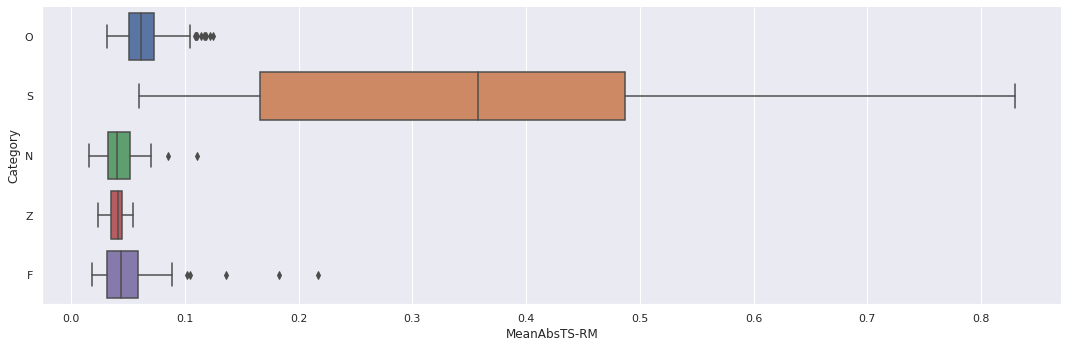

In [9]:
display(Markdown("## Catplot of Category/MeanAbsTS-RM"))
sb.catplot(x="MeanAbsTS-RM", y="Category", data=variableDF, kind="box", aspect=3, height=5);

## Catplot of Category/CountPeaksRM

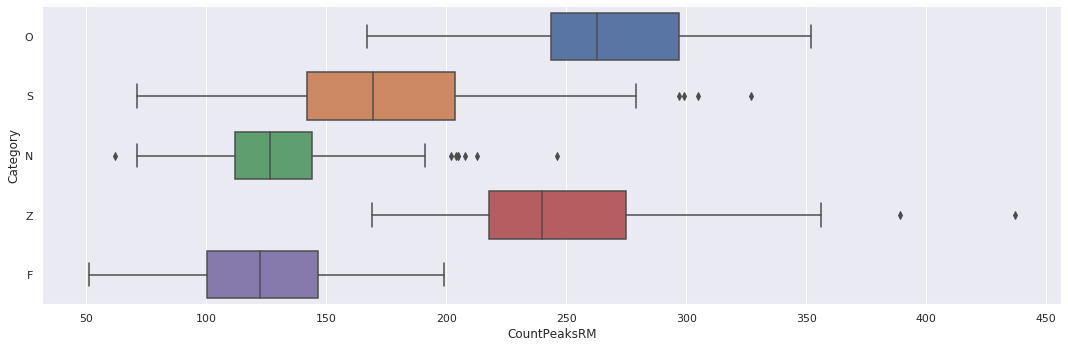

In [10]:
display(Markdown("## Catplot of Category/CountPeaksRM"))
sb.catplot(x="CountPeaksRM", y="Category", data=variableDF, kind="box", aspect=3, height=5);

# Data Classification

- First, classification is done on raw time series data

- Next, classification is done using the extracted features:

    - Univariate classification is applied for the two variables individually first

    - This is followed by multivariate classification

## Classifying on Time-Series data directly

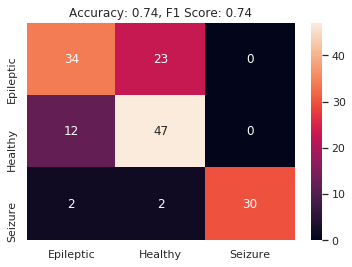

In [11]:
X = pd.DataFrame(full_df[list(range(0, 4097))])
y = full_df["Class"].replace({
    "Z": "Healthy",
    "O": "Healthy",
    "N": "Epileptic",
    "F": "Epileptic",
    "S": "Seizure"
})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fitting random forest model
rfc = RandomForestClassifier(max_depth=3)
rfc.fit(X_train, y_train.values.ravel())

y_test_pred_rf = rfc.predict(X_test)
matrix = confusion_matrix(y_test, y_test_pred_rf)

display(Markdown("## Classifying on Time-Series data directly"))

# plotting the confusion matrix for test set
ax=sb.heatmap(matrix, annot = True, fmt = ".0f", xticklabels = rfc.classes_, yticklabels = rfc.classes_);

plt.title(f'Accuracy: {rfc.score(X_test, y_test):.2f}, F1 Score: {f1_score(y_test, y_test_pred_rf, average="weighted"):.2f}')
plt.show()

## Classifier Model (MeanAbsTS-RM)

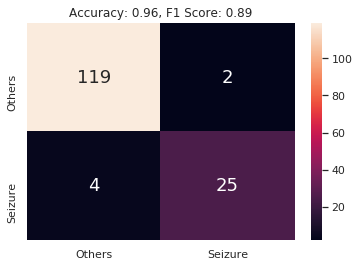

In [12]:
features=pd.DataFrame(variableDF['MeanAbsTS-RM'])
labels=pd.DataFrame(variableDF["CategoryHEv/sS"])

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)

# fitting random forest model
rfc = RandomForestClassifier(max_depth=3)
rfc.fit(train_features, train_labels.values.ravel())

y_test_pred_rf = rfc.predict(test_features)
matrix = confusion_matrix(test_labels, y_test_pred_rf)

display(Markdown("## Classifier Model (MeanAbsTS-RM)"))

# plotting the confusion matrix for test set
ax=sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, xticklabels=rfc.classes_, yticklabels=rfc.classes_)

plt.title(f'Accuracy: {rfc.score(test_features, test_labels):.2f}, F1 Score: {f1_score(test_labels, y_test_pred_rf, pos_label="Seizure"):.2f}')
plt.show()

## Classifier Model (CountPeaksRM)

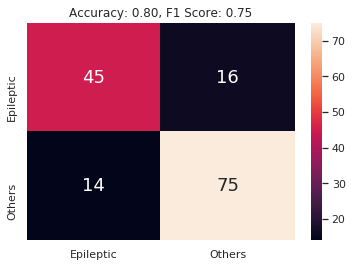

In [13]:
features= pd.DataFrame(variableDF[['CountPeaksRM']])
labels=pd.DataFrame(variableDF['CategoryHSv/sE'])

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)

# fitting random forest model
rfc = RandomForestClassifier(max_depth=3)
rfc.fit(train_features, train_labels.values.ravel())

y_test_pred_rf = rfc.predict(test_features)
matrix = confusion_matrix(test_labels, y_test_pred_rf)

display(Markdown("## Classifier Model (CountPeaksRM)"))

# plotting the confusion matrix for test set
ax=sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, xticklabels=rfc.classes_, yticklabels=rfc.classes_)

plt.title(f'Accuracy: {rfc.score(test_features, test_labels):.2f}, F1 Score: {f1_score(test_labels, y_test_pred_rf, pos_label="Epileptic"):.2f}')
plt.show()

## Classifier Model (MeanAbsTS-RM and CountPeaksRM)

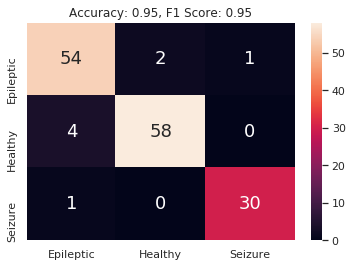

In [14]:
features= pd.DataFrame(variableDF[['MeanAbsTS-RM','CountPeaksRM']])
labels=pd.DataFrame(variableDF['CategoryHv/sEv/sS'])

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)

# fitting random forest model
rfc = RandomForestClassifier(max_depth=5)
rfc.fit(train_features, train_labels.values.ravel())

y_test_pred_rf = rfc.predict(test_features)
matrix = confusion_matrix(test_labels, y_test_pred_rf)

display(Markdown("## Classifier Model (MeanAbsTS-RM and CountPeaksRM)"))

# plotting the confusion matrix for test set
ax=sb.heatmap(matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, xticklabels=rfc.classes_, yticklabels=rfc.classes_)

plt.title(f'Accuracy: {rfc.score(test_features, test_labels):.2f}, F1 Score: {f1_score(test_labels, y_test_pred_rf, average="weighted"):.2f}')
plt.show()

# Feature Extraction: Frequency

- Direct comparison between time series not possible because of alignment

- Convert to Frequency Domain by performing Fast Fourier Transform (FFT) on time series data

    - Extracts out base frequency components

In [15]:
def process_fft(datapoints):    
    # returns fft_points, fft_bin_freq
    
    # datapoints / 2 (negative bins are symmetrical and thus can be ignored)
    # samples are returned
    fft = abs(np.fft.rfft(datapoints))
    # half the number of data points returned because the data has already
    # been filtered at 40Hz and we don't expect to see anything above
    fft = fft[:int(len(fft)/2)]
    
    fft_freq = np.fft.fftfreq(len(datapoints), 1/SAMPLING_FREQ)
    
    fft_freq = fft_freq[:len(fft)]
    return fft, fft_freq

The source states that the following series are exemplary time series for their category:
* Set A/5 (Healthy, Eyes open): Z093
* Set B/4 (Healthy, Eyes closed): O015
* Set C/3 (Patient, Opposite hemisphere from Set D): N062
* Set D/2 (Patient, Epileptogenic zone): F021
* Set E/1 (Patient, segment selected from all sites with seizure activity): S056

# Time Domain vs Frequency Domain

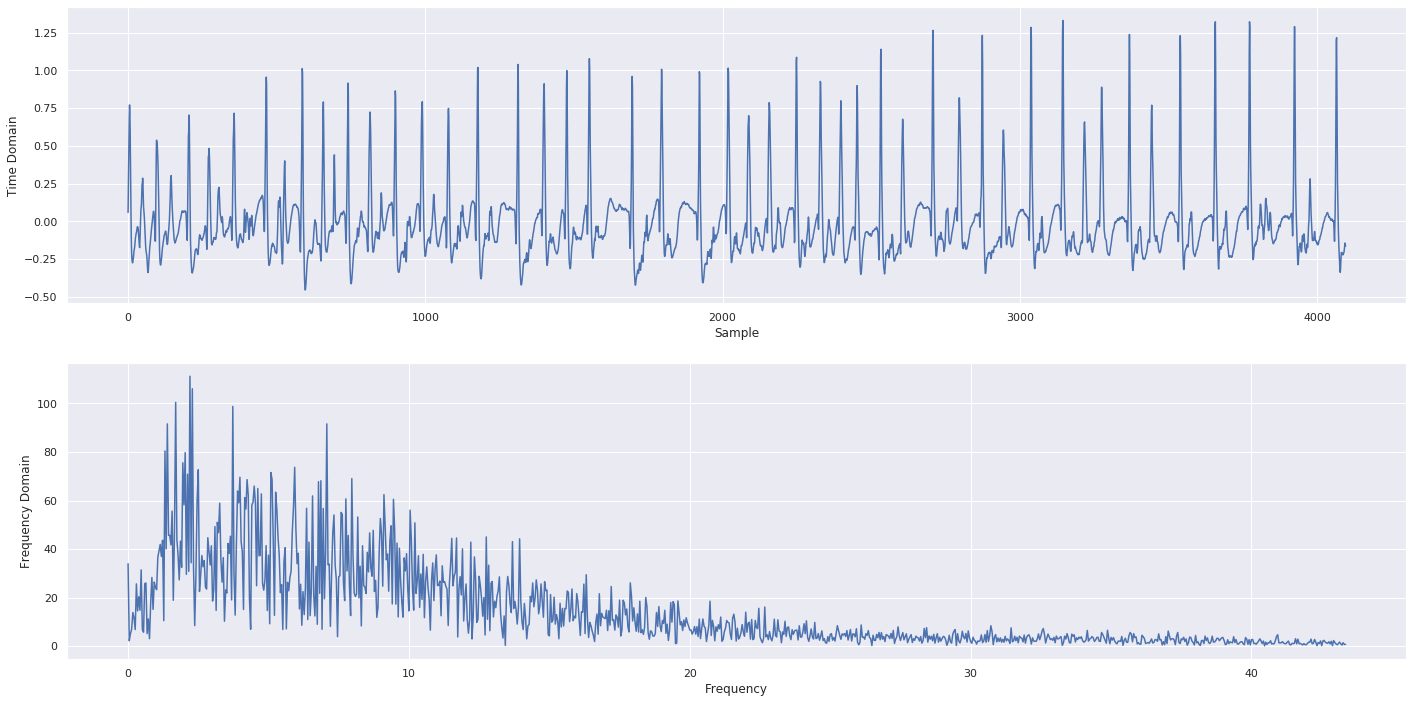

In [16]:
data = pd.DataFrame(lpf(pd.read_csv(f'seizure/{fname}.txt', header=None)))

fft, fft_freq = process_fft(data.transpose().iloc[0])
df = pd.DataFrame(fft, fft_freq)
df.index.name = "Frequency"
df.rename(columns={0: "Frequency Domain"}, inplace=True)
df.reset_index(inplace=True)

data.index.name = "Sample"
data.reset_index(inplace=True)
data.rename(columns={0: "Time Domain"}, inplace=True)

fig, axes = plt.subplots(2, 1, figsize=(24, 12))

display(Markdown("# Time Domain vs Frequency Domain"))
sb.lineplot(x="Sample", y="Time Domain", data=data, ax=axes[0])
sb.lineplot(x="Frequency", y="Frequency Domain", data=df, axes=axes[1]);

In [17]:
overall = []

for fname in ["Z093", "O015", "N062", "F021", "S056"]:
    data = pd.read_csv(f'seizure/{fname}.txt', header=None)
    fft, fft_freq = process_fft(data.transpose().iloc[0])
    
    df = pd.DataFrame(fft, fft_freq)
    df.index.name = "frequency"
    df.rename(columns={0: "magnitude"}, inplace=True)
    df.reset_index(inplace=True)
    
    df["class"] = f'{fname} - {LABELS[fname[0]]}'
    overall.append(df)

overall_df = pd.concat(overall, ignore_index=True)

display(Markdown("# Data in Frequency Domain"))

fig = px.line(overall_df, x="frequency", y="magnitude", color="class", labels={
    "frequency": "Frequency (Hz)",
    "magnitude": "Magnitude",
    "class": "Class"
})

fig.update_traces({
    "line_width": 1
})

fig.update_layout(legend={
    "xanchor": "right",
    "x": 1,
    "y": 1
})

# Data in Frequency Domain

In [18]:
fft_data = []
fft_freq = False

for index, row in full_df[range(0, 4096+1)].iterrows():
    fft, _fft_freq = process_fft(row.to_numpy())
    if fft_freq is False:
        fft_freq = _fft_freq
    
    fft_data.append(fft)

fft_df = pd.concat([pd.DataFrame(fft_data), cls_df], axis="columns")

assert fft_df.shape == (500, 1026)
display(fft_df.head())

0          1          2          3          4          5  \
0  476.724838   2.064837   2.458517   1.103178   6.535044   3.909978   
1  159.555957  19.640740  23.731190  23.498837  37.963226  37.469362   
2  329.106180   0.417635   3.200592   3.220647  22.511111   8.666406   
3   70.325900  12.074082  43.250228  31.306724  13.991097  34.037123   
4   13.767472   3.550191   4.101644  23.640869  13.623012  42.364420   

           6          7          8          9  ...      1016      1017  \
0  15.346983  10.401491  14.414816  12.756516  ...  0.881936  0.671309   
1  45.842110  23.065295  31.164584   1.706184  ...  0.918642  0.341596   
2  15.028341   5.871170  11.326499  14.552363  ...  0.256435  0.622107   
3  14.841989  42.323095  43.180044  26.925373  ...  2.704925  1.123007   
4  22.321929  13.221386  14.414229  13.699876  ...  1.180787  0.553476   

       1018      1019      1020      1021      1022      1023  Class  \
0  0.813667  0.642092  0.721856  0.438105  0.739139  0.393423      O   
1  0.095325  0.713225  0.313674  0.990283  0.608987  0.811598      S   
2  0.377309  0.411229  0.569882  1.045437  1.381647  0.252926      S   
3  3.399538  0.830881  4.255519  4.031483  5.428871  2.141327      S   
4  0.742681  0.346914  2.847804  1.341044  1.850086  2.058306      O   

               FullClass  
0  Healthy (Eyes Closed)  
1       Seizure Activity  
2       Seizure Activity  
3       Seizure Activity  
4  Healthy (Eyes Closed)  

[5 rows x 1026 columns]

In [19]:
stats_df = fft_df.groupby("FullClass")[list(range(0, 1024))].quantile(q=0.5).unstack().reset_index()
# replace bin index with the actual frequency of that bin
stats_df["level_0"].replace({i: v for i, v in enumerate(fft_freq)}, inplace=True)
stats_df.rename(columns={"level_0": "Frequency", 0: "Magnitude"}, inplace=True)

display(Markdown("## Median of Each FFT Bin"))

fig = px.line(stats_df, x="Frequency", y="Magnitude", color="FullClass", labels={
    "Frequency": "Frequency (Hz)",
    "FullClass": "Full Class"
})

fig.update_traces({
    "line_width": 1
})

fig.update_layout(legend={
    "xanchor": "right",
    "x": 1,
    "y": 1
})

## Median of Each FFT Bin

## Classifier Model (FFT)

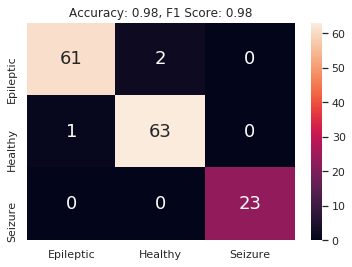

In [20]:
X = pd.DataFrame(fft_df[list(range(0, 600))])
y = fft_df["Class"].replace({
    "Z": "Healthy",
    "O": "Healthy",
    "N": "Epileptic",
    "F": "Epileptic",
    "S": "Seizure"
})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# fitting random forest model
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)

rf_y_test_pred = rf_clf.predict(X_test)
rf_matrix = confusion_matrix(y_test, rf_y_test_pred)

display(Markdown("## Classifier Model (FFT)"))

# plotting the confusion matrix for test set
ax=sb.heatmap(rf_matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)

plt.title(f'Accuracy: {rf_clf.score(X_test, y_test):.2f}, F1 Score: {f1_score(y_test, rf_y_test_pred, average="weighted"):.2f}')
plt.show()

# Classifier Model

- Random Forest Classifier - Improvement over certain issues with Decision Trees:

    - Overfitting
    
    - Variance
    
    - Different features are randomly used to form multiple trees, whose results are aggregated
    
        - Reduces chance of one bad "split" affecting final result significantly

# Classifier Model (Final With 3 Features)

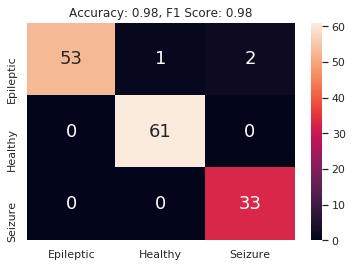

In [21]:
X = pd.DataFrame(fft_df[list(range(0, 600))])
X['MeanAbsTS-RM']=variableDF['MeanAbsTS-RM']
X['CountPeaksRM']=variableDF['CountPeaksRM']                             
y = fft_df["Class"].replace({
    "Z": "Healthy",
    "O": "Healthy",
    "N": "Epileptic",
    "F": "Epileptic",
    "S": "Seizure"
})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# fitting random forest model
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)

rf_y_test_pred = rf_clf.predict(X_test)
rf_matrix = confusion_matrix(y_test, rf_y_test_pred)

display(Markdown("# Classifier Model (Final With 3 Features)"))

# plotting the confusion matrix for test set
ax=sb.heatmap(rf_matrix, annot = True, fmt=".0f", annot_kws={"size": 18}, xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)

plt.title(f'Accuracy: {rf_clf.score(X_test, y_test):.2f}, F1 Score: {f1_score(y_test, rf_y_test_pred, average="weighted"):.2f}')
plt.show()

# Data Contamination

Page 2 of the [data description](http://users.fs.cvut.cz/ivo.bukovsky/PROJEKT/Data/Realna/BIO/EEG/reference/PRE61907.pdf) states that "Five sets denoted (A–E) each containing 100 single-channel EEG segments of 23.6-sec duration, were composed for the study. These segments were selected and cut out from **continuous multichannel EEG recordings** after visual inspection for artifacts, e.g., due to muscle activity or eye movements. In addition, the segments had to fulfill a stationarity criterion described in detail in Sec. II B. **Sets A and B consisted of segments taken from surface EEG recordings that were carried out on five healthy volunteers** using a standardized electrode placement scheme (cf. Fig. 1). Volunteers were relaxed in an awake state with eyes open (A) and eyes closed (B), respectively. **Sets C, D, and E originated from our EEG archive of presurgical diagnosis. For the present study EEGs from five patients** were selected, all of whom had achieved complete seizure control after resection of one of the hippocampal formations, which was therefore correctly diagnosed to be the epileptogenic zone (cf. Fig. 2). Segments in set D were recorded from within the epileptogenic zone, and those in set C from the hippocampal formation of the opposite hemisphere of the brain. While sets C and D contained only activity measured during seizure free intervals, set E only contained seizure activity. Here segments were selected from all recording sites exhibiting ictal activity."

The diagrams below illustrates this: 5 epileptic patients provide 300 sets of EEG data. We assume that more than one set of EEG data per patient is included (illustrated by Patient 5 providing C003, D003, E003 and C100, D100, E100 in the diagram below) as there are more sets of data than patients.

When we apply the standard machine learning pipeline, we split these 300 sets of EEG data into train and test sets accordingly. These train and test sets will contain sets of EEG data from the same patient (for example, C003, D003, E003 ends up in the train dataset, while C100, D100, E100 ends up in the test dataset).

We assume that because C003, D003, E003 and C100, D100, E100 come from the same patient (and samples from the same patient are cut from continuous EEG recordings), EEG samples provided by the same patient has similar characteristics (eg C003 and C100). This would result in the test set being contaminated, explaining the extremely high prediction accuracies of our models even when only one or two features are used.

Unfortunately, we cannot see a way to identify which patients contributed to which set of EEG data.

# Data Contamination

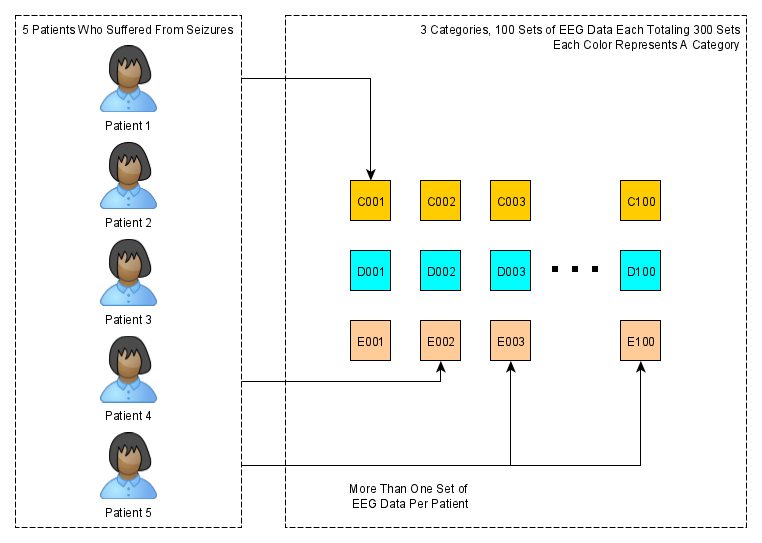

# Data Contamination

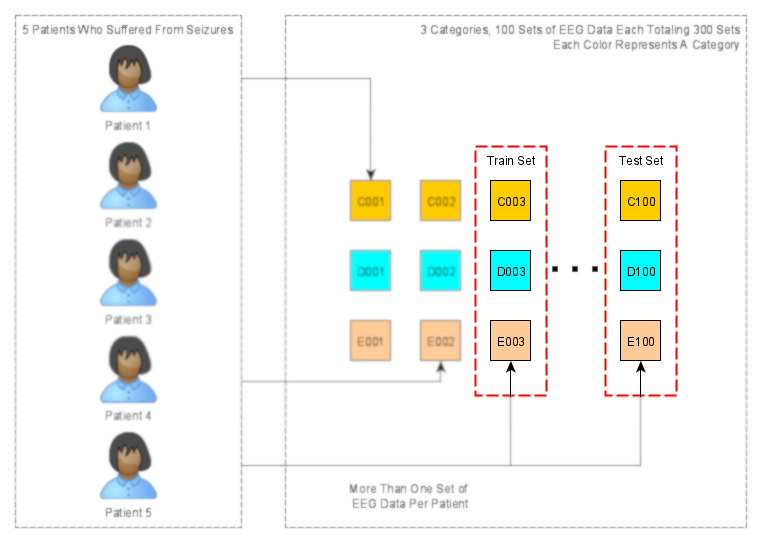

# Learning Points
- Methods for extracting features from Time-Series data

- Signal Processing

- Using Plotly for interactive visualisations

- Random Forest Classifier

# Work Done

- Justin
    - Data Loading & Processing
    - Feature Extraction
        - Frequency Domain

- Rachita
    - Data Exploration
    - Feature Extraction:
        - Rolling Mean
        - Counting Peaks

- Ming Wei & Yi Xian
    - Classification on Time-Series Data

# Presentation Slides

The material used during the presentation can be found at https://justins.in/idsai#/. A [script](https://github.com/JustinOng/reveal-multiplex) displays an exported copy of this notebook.